# AML Final Project

### Made by Machin Ivan

Dataset, used in this project: Census-Income (KDD) Data Set (link: https://archive.ics.uci.edu/ml/datasets/Census-Income+%28KDD%29)

## 1. Data exploration

Let's solve binary classification, target variable will be target columm in dataset that takes 2 values: ' - 50000.' and ' 50000+.'. For evaluating the chosen model for this assignment let's use balanced accuracy metric.

To validate performance of the model, the stratified KFold cross-validation strategy will be used.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [3]:
train_df.head()

,AAGE,ACLSWKR,ADTIND,ADTOCC,AHGA,AHRSPAY,AHSCOL,AMARITL,AMJIND,AMJOCC,...,PARENT,PEFNTVTY,PEMNTVTY,PENATVTY,PRCITSHP,SEOTR,VETQVA,VETYN,WKSWORK,target
0,64,Not in universe,0,0,7th and 8th grade,0,Not in universe,Married-civilian spouse present,Not in universe or children,Not in universe,...,Not in universe,Cuba,Cuba,Cuba,Foreign born- U S citizen by naturalization,0,Not in universe,2,0,- 50000.
1,16,Not in universe,0,0,9th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,- 50000.
2,45,Private,39,19,10th grade,0,Not in universe,Married-civilian spouse present,Personal services except private HH,Sales,...,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,44,- 50000.
3,34,Not in universe,0,0,High school graduate,0,Not in universe,Divorced,Not in universe or children,Not in universe,...,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,24,- 50000.
4,50,Local government,43,10,Masters degree(MA MS MEng MEd MSW MBA),0,Not in universe,Never married,Education,Professional specialty,...,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,50000+.


In [4]:
train_df.shape, test_df.shape

((199523, 40), (99762, 40))

In [5]:
# replacing Not in universe to nan, checking nan ratio in every column
train_df.replace(' Not in universe', np.nan, inplace=True)
test_df.replace(' Not in universe', np.nan, inplace=True)
train_df.replace(' ?', np.nan, inplace=True)
test_df.replace(' ?', np.nan, inplace=True)

In [6]:
# dropping columns with more than 33 percent of nan values
nan_cols = [c for c in train_df.columns 
            if round(train_df[c].isna().sum() / train_df.shape[0], 2) >= 0.33]
print(*nan_cols)
train_df.drop(nan_cols, axis=1, inplace=True)
test_df.drop(nan_cols, axis=1, inplace=True)

ACLSWKR AHSCOL AMJOCC AUNMEM AUNTYPE GRINREG GRINST MIGMTR1 MIGMTR3 MIGMTR4 MIGSUN PARENT VETQVA


In [7]:
# extracting X, y from train and test dataframes
y = train_df.target
X = train_df.drop('target', axis=1)

y_test = test_df.target
X_test = test_df.drop('target', axis=1)

# building mapping to encode target in both dfs as 1 and 0
target_mapping = {' - 50000.': 0, ' 50000+.': 1}

y = y.map(target_mapping)
y_test = y_test.map(target_mapping)

y[:5]

0    0
1    0
2    0
3    0
4    1
Name: target, dtype: int64

<AxesSubplot:xlabel='target', ylabel='count'>

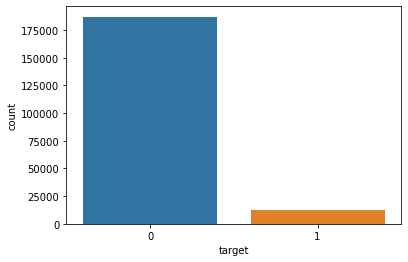

In [8]:
sns.countplot(x=y)

In [9]:
X.columns

Index(['AAGE', 'ADTIND', 'ADTOCC', 'AHGA', 'AHRSPAY', 'AMARITL', 'AMJIND',
       'ARACE', 'AREORGN', 'ASEX', 'AWKSTAT', 'CAPGAIN', 'CAPLOSS', 'DIVVAL',
       'FILESTAT', 'HHDFMX', 'HHDREL', 'MIGSAME', 'NOEMP', 'PEFNTVTY',
       'PEMNTVTY', 'PENATVTY', 'PRCITSHP', 'SEOTR', 'VETYN', 'WKSWORK'],
      dtype='object')

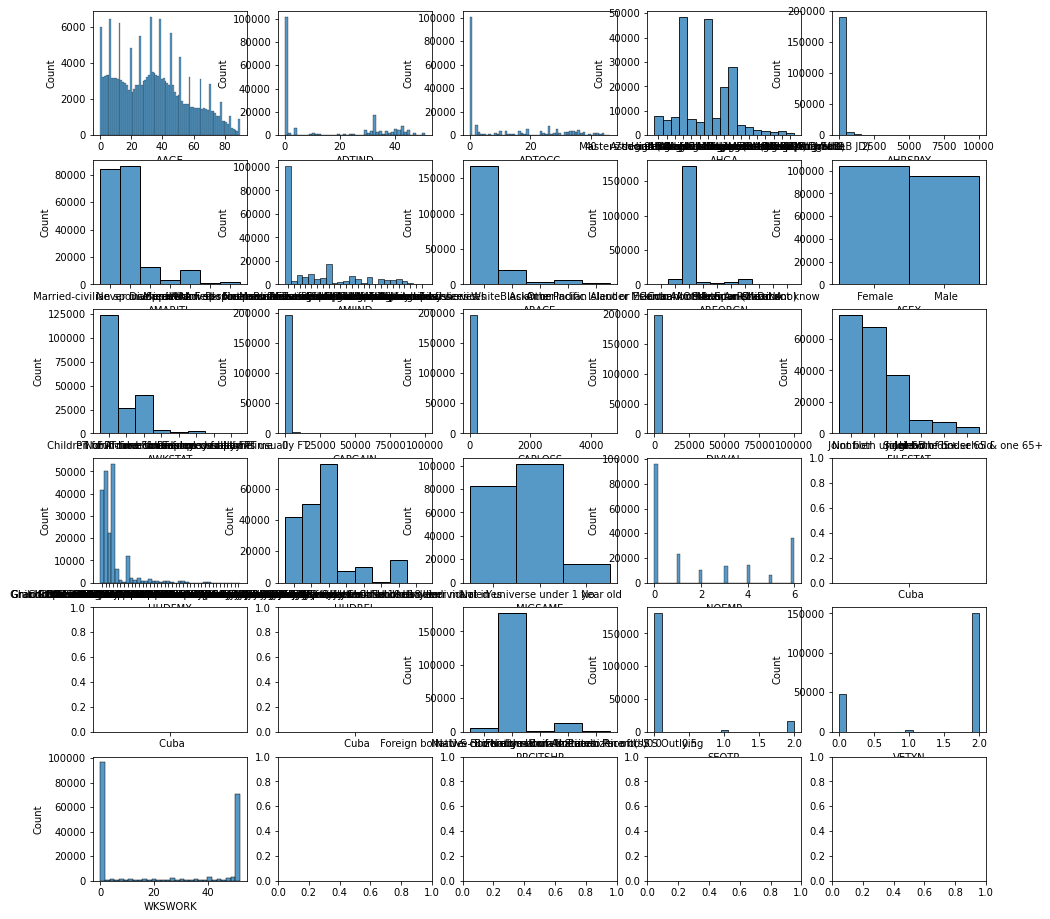

In [10]:
# plotting distribution if possible
fig, axes = plt.subplots(6, 5, figsize=(16,16))

for i in range(len(X.columns)):
    try:
        sns.histplot(X[X.columns[i]], ax=axes[i//5, i % 5])
    except:
        pass

<AxesSubplot:>

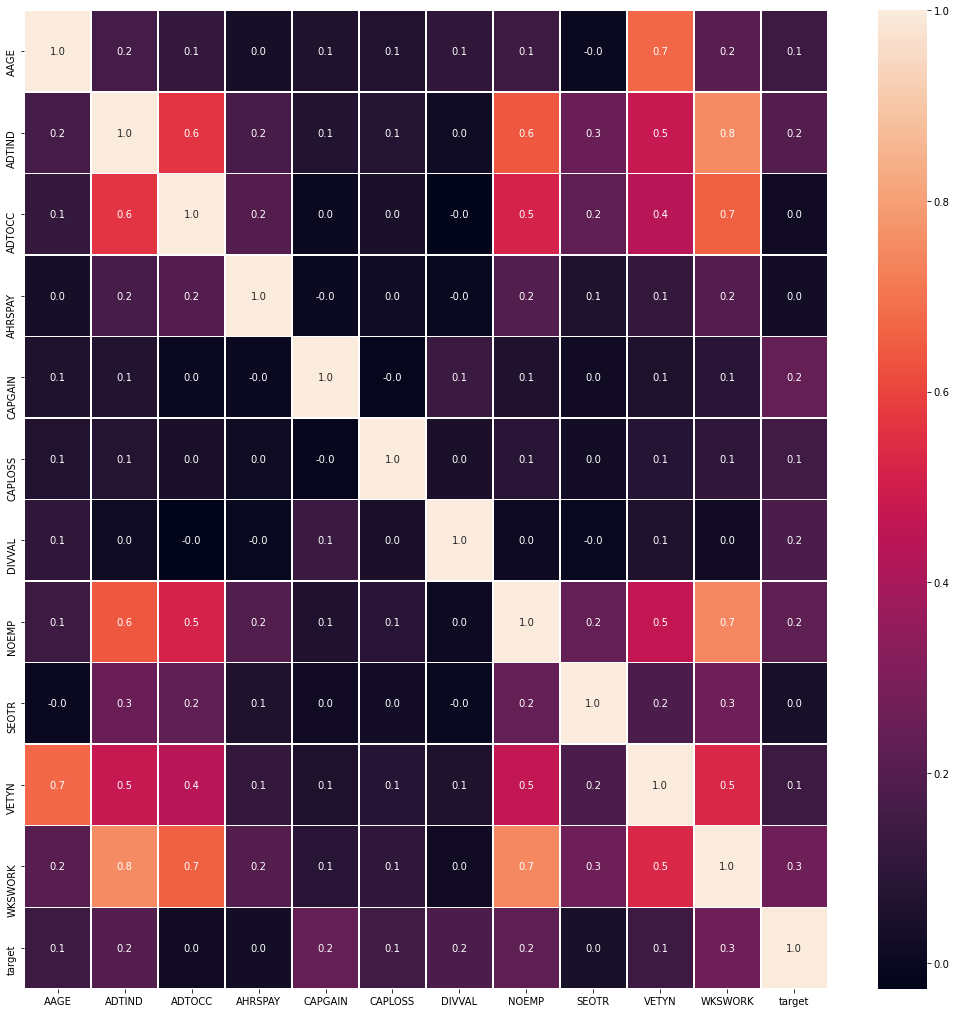

In [11]:
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(pd.concat([X, y], axis=1).corr(), 
            annot=True, linewidths=.5, fmt= '.1f',ax=ax)

### Feature engineering

In [12]:
X[:5]

,AAGE,ADTIND,ADTOCC,AHGA,AHRSPAY,AMARITL,AMJIND,ARACE,AREORGN,ASEX,...,HHDREL,MIGSAME,NOEMP,PEFNTVTY,PEMNTVTY,PENATVTY,PRCITSHP,SEOTR,VETYN,WKSWORK
0,64,0,0,7th and 8th grade,0,Married-civilian spouse present,Not in universe or children,White,Cuban,Female,...,Spouse of householder,Yes,0,Cuba,Cuba,Cuba,Foreign born- U S citizen by naturalization,0,2,0
1,16,0,0,9th grade,0,Never married,Not in universe or children,White,Mexican-American,Male,...,Child under 18 never married,Not in universe under 1 year old,0,United-States,United-States,United-States,Native- Born in the United States,0,2,0
2,45,39,19,10th grade,0,Married-civilian spouse present,Personal services except private HH,White,All other,Female,...,Spouse of householder,Not in universe under 1 year old,1,United-States,United-States,United-States,Native- Born in the United States,0,2,44
3,34,0,0,High school graduate,0,Divorced,Not in universe or children,White,All other,Male,...,Householder,Not in universe under 1 year old,3,United-States,United-States,United-States,Native- Born in the United States,0,2,24
4,50,43,10,Masters degree(MA MS MEng MEd MSW MBA),0,Never married,Education,White,All other,Female,...,Householder,Not in universe under 1 year old,6,United-States,United-States,United-States,Native- Born in the United States,0,2,52


In [13]:
num_cols = [c for c in X.columns if X[c].dtype == 'int64'
                                        or X[c].dtype == 'float64']
print('Numeric columns:' , *num_cols)

cat_cols = [c for c in X.columns if X[c].dtype == 'object']
print('Categorical columns:', *cat_cols)

Numeric columns: AAGE ADTIND ADTOCC AHRSPAY CAPGAIN CAPLOSS DIVVAL NOEMP SEOTR VETYN WKSWORK
Categorical columns: AHGA AMARITL AMJIND ARACE AREORGN ASEX AWKSTAT FILESTAT HHDFMX HHDREL MIGSAME PEFNTVTY PEMNTVTY PENATVTY PRCITSHP


In [14]:
X[cat_cols].head()

,AHGA,AMARITL,AMJIND,ARACE,AREORGN,ASEX,AWKSTAT,FILESTAT,HHDFMX,HHDREL,MIGSAME,PEFNTVTY,PEMNTVTY,PENATVTY,PRCITSHP
0,7th and 8th grade,Married-civilian spouse present,Not in universe or children,White,Cuban,Female,Children or Armed Forces,Nonfiler,Spouse of householder,Spouse of householder,Yes,Cuba,Cuba,Cuba,Foreign born- U S citizen by naturalization
1,9th grade,Never married,Not in universe or children,White,Mexican-American,Male,Not in labor force,Nonfiler,Child <18 never marr not in subfamily,Child under 18 never married,Not in universe under 1 year old,United-States,United-States,United-States,Native- Born in the United States
2,10th grade,Married-civilian spouse present,Personal services except private HH,White,All other,Female,Full-time schedules,Joint both under 65,Spouse of householder,Spouse of householder,Not in universe under 1 year old,United-States,United-States,United-States,Native- Born in the United States
3,High school graduate,Divorced,Not in universe or children,White,All other,Male,Not in labor force,Single,Nonfamily householder,Householder,Not in universe under 1 year old,United-States,United-States,United-States,Native- Born in the United States
4,Masters degree(MA MS MEng MEd MSW MBA),Never married,Education,White,All other,Female,Full-time schedules,Single,Nonfamily householder,Householder,Not in universe under 1 year old,United-States,United-States,United-States,Native- Born in the United States


In [15]:
# only ordinal column is AHGA
X.AHGA.unique()
ahga_mapping = {' Children': 0, ' Less than 1st grade': 0, ' 1st 2nd 3rd or 4th grade': 0,
                ' 5th or 6th grade': 0, ' 7th and 8th grade': 0, ' 9th grade': 0, ' 10th grade': 1,
                ' 11th grade': 1, ' 12th grade no diploma': 1, ' High school graduate': 2, 
                ' Some college but no degree': 2, ' Associates degree-occup /vocational': 3, 
                ' Associates degree-academic program': 3, ' Bachelors degree(BA AB BS)': 4,
                ' Masters degree(MA MS MEng MEd MSW MBA)': 5, ' Prof school degree (MD DDS DVM LLB JD)': 6, 
                ' Doctorate degree(PhD EdD)': 7}
X.AHGA = X.AHGA.map(ahga_mapping)
X_test.AHGA = X_test.AHGA.map(ahga_mapping)
cat_cols.remove('AHGA')

# converting binary columns into 0 and 1
asex_mapping = {' Male': 1, ' Female': 0}
X.ASEX = X.ASEX.map(asex_mapping)
X_test.ASEX = X_test.ASEX.map(asex_mapping)

In [16]:
# setting a list of low cardinality columns that will be encoded with help of One Hot Encoder
cat_cols_to_oh = [c for c in cat_cols if X[c].dtype == 'object'
                                        and X[c].nunique() <= 10]
print(*cat_cols_to_oh)
hc_cat_cols = list(set(cat_cols) - set(cat_cols_to_oh))
print(hc_cat_cols)

AMARITL ARACE AREORGN AWKSTAT FILESTAT HHDREL MIGSAME PRCITSHP
['PENATVTY', 'PEMNTVTY', 'AMJIND', 'HHDFMX', 'ASEX', 'PEFNTVTY']


In [17]:
X[hc_cat_cols]

,PENATVTY,PEMNTVTY,AMJIND,HHDFMX,ASEX,PEFNTVTY
0,Cuba,Cuba,Not in universe or children,Spouse of householder,0,Cuba
1,United-States,United-States,Not in universe or children,Child <18 never marr not in subfamily,1,United-States
2,United-States,United-States,Personal services except private HH,Spouse of householder,0,United-States
3,United-States,United-States,Not in universe or children,Nonfamily householder,1,United-States
4,United-States,United-States,Education,Nonfamily householder,0,United-States
...,...,...,...,...,...,...
199518,United-States,United-States,Retail trade,Householder,1,United-States
199519,United-States,United-States,Not in universe or children,Child <18 never marr not in subfamily,0,United-States
199520,United-States,United-States,Other professional services,Householder,1,United-States
199521,United-States,Canada,Construction,Householder,1,United-States


In [18]:
# dealing with high cardinality columns
# uniting some values in HHDFMX column
X.loc[X.HHDFMX.str.contains('Child'), 'HHDFMX'] = ' Child'
X.loc[X.HHDFMX.str.contains('Grandchild'), 'HHDFMX'] = ' Grandchild'
X.loc[X.HHDFMX.str.contains('Other Rel'), 'HHDFMX'] = ' Other Rel'
X.loc[X.HHDFMX.str.contains('unrelated subfamily'), 'HHDFMX'] = ' Unrelated subfamily'

X_test.loc[X_test.HHDFMX.str.contains('Child'), 'HHDFMX'] = ' Child'
X_test.loc[X_test.HHDFMX.str.contains('Grandchild'), 'HHDFMX'] = ' Grandchild'
X_test.loc[X_test.HHDFMX.str.contains('Other Rel'), 'HHDFMX'] = ' Other Rel'
X_test.loc[X_test.HHDFMX.str.contains('unrelated subfamily'), 'HHDFMX'] = ' Unrelated subfamily'

# converting AMJIND feature to binary where 1 means person has some working specialty and 0 if not
X.loc[~X.AMJIND.str.contains('Not in universe', na=False), 'AMJIND'] = 1
X.loc[X.AMJIND.str.contains('Not in universe', na=False), 'AMJIND'] = 0
X.AMJIND = X.AMJIND.astype('int64')
X_test.loc[~X_test.AMJIND.str.contains('Not in universe', na=False), 'AMJIND'] = 1
X_test.loc[X_test.AMJIND.str.contains('Not in universe', na=False), 'AMJIND'] = 0
X_test.AMJIND = X_test.AMJIND.astype('int64')

# dropping columns with parents country of birth, leaving only country of birth of person
# transforming PENATVTY column in binary column with values 1 if person born in USA and 0 if not because 
# 88 percent of respondents were born in USA
cols_to_drop = ['PEFNTVTY', 'PEMNTVTY']
X.drop(cols_to_drop, axis=1, inplace=True)
X_test.drop(cols_to_drop, axis=1, inplace=True)
hc_cat_cols = [c for c in hc_cat_cols if c not in cols_to_drop]

X.loc[X.PENATVTY != ' United-States', 'PENATVTY'] = 0
X.loc[X.PENATVTY == ' United-States', 'PENATVTY'] = 1
X.PENATVTY = X.PENATVTY.astype('int64')
X_test.loc[X_test.PENATVTY != ' United-States', 'PENATVTY'] = 0
X_test.loc[X_test.PENATVTY == ' United-States', 'PENATVTY'] = 1
X_test.PENATVTY = X_test.PENATVTY.astype('int64')

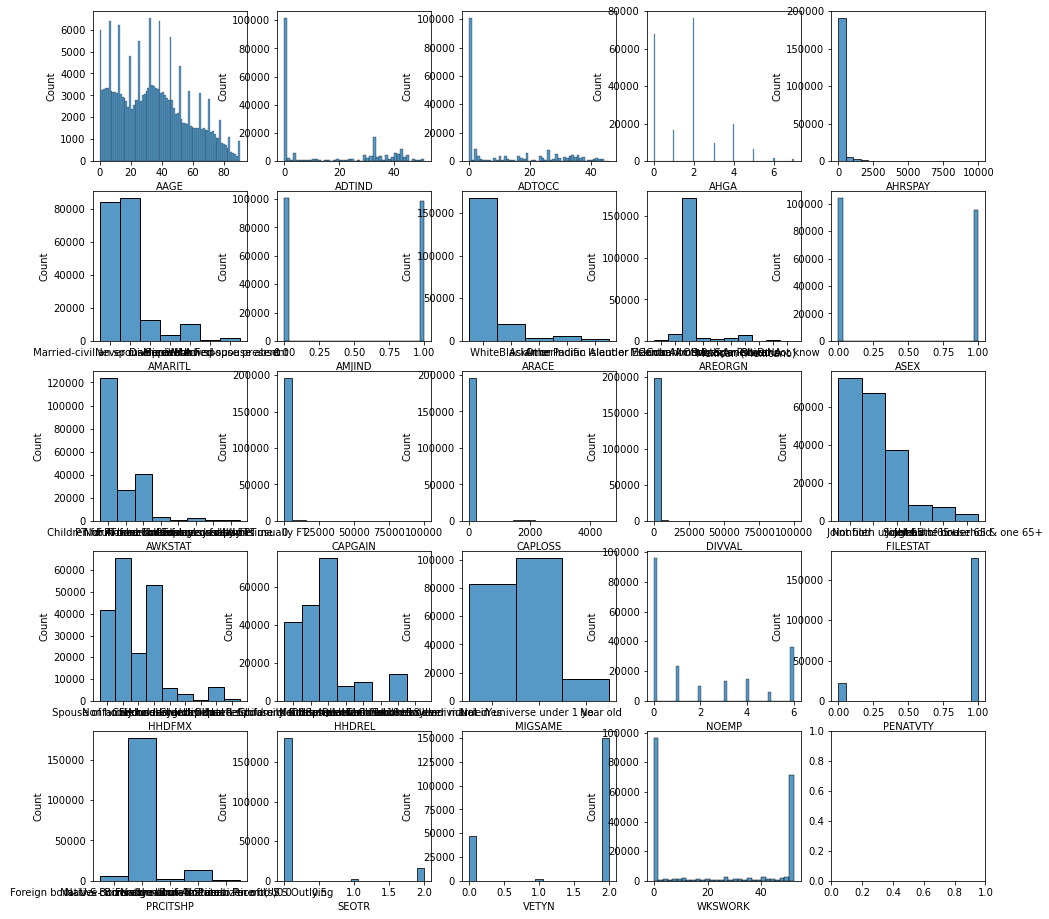

In [19]:
# visualisation after feature engineering
fig, axes = plt.subplots(5, 5, figsize=(16,16))

for i in range(len(X.columns)):
    try:
        sns.histplot(X[X.columns[i]], ax=axes[i//5, i % 5])
    except:
        pass

<AxesSubplot:>

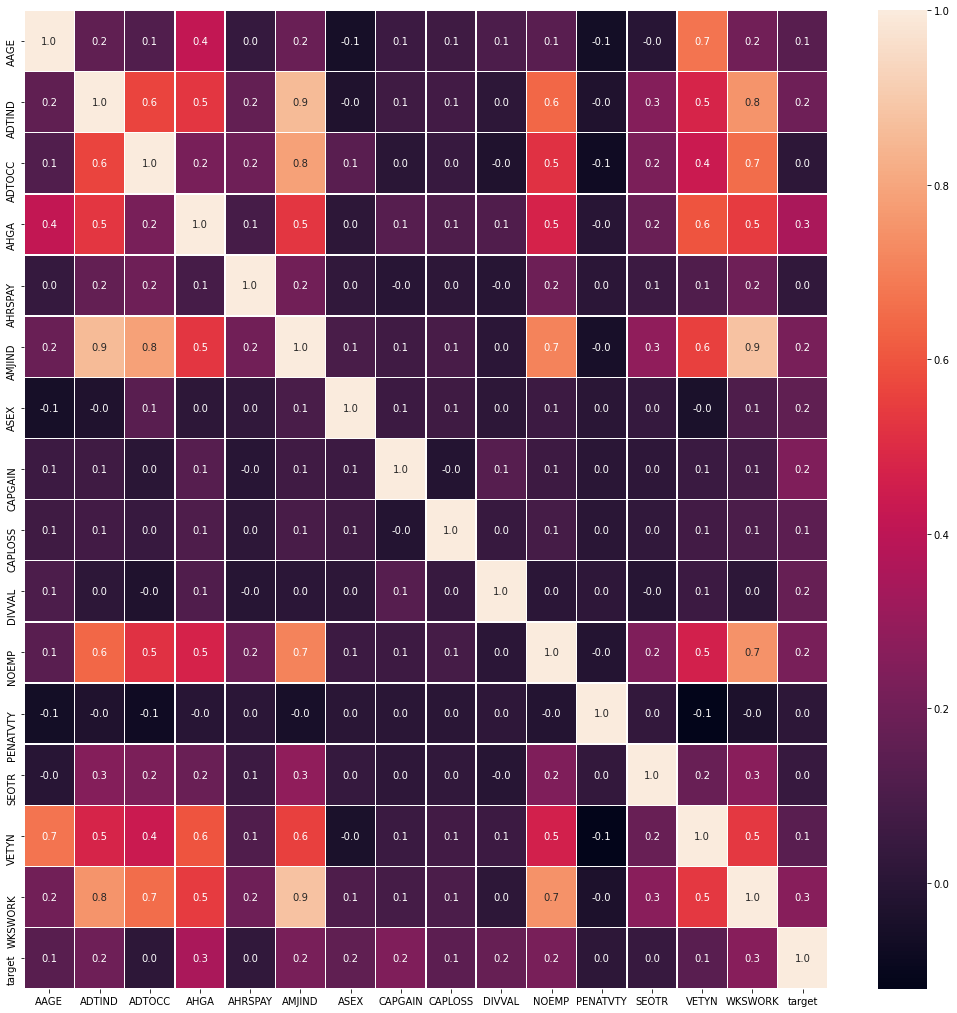

In [20]:
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(pd.concat([X, y], axis=1).corr(), 
            annot=True, linewidths=.5, fmt= '.1f',ax=ax)

## 2. Data preparation

In [21]:
bin_cols = [c for c in X.columns if X[c].nunique() == 2]
num_cols = [c for c in X.columns if (X[c].dtype == 'float64'
                                   or X[c].dtype == 'int64')
                                   and c not in bin_cols]
cat_cols = [c for c in X.columns if X[c].dtype == 'object']

assert (len(bin_cols) + len(num_cols) + len(cat_cols)) == X.shape[1]

In [22]:
# searching for nan values
X.isna().sum().sum(), X_test.isna().sum().sum()

(0, 0)

In [23]:
# encoding cat cols using pandas get_dummies function
for col in cat_cols:
    df = pd.DataFrame(pd.get_dummies(X[col]))
    df1 = pd.DataFrame(pd.get_dummies(X_test[col]))
    
    names = [f'{col}{i}' for i in range(df.shape[1])]
    df.columns = names
    df1.columns = names
    
    X = pd.concat([X, df], axis=1)
    X.drop(col, axis=1, inplace=True)
    X_test = pd.concat([X_test, df1], axis=1)
    X_test.drop(col, axis=1, inplace=True)

In [24]:
def num_std_scaler(df, col):
    """
    Scales numerical feature of dataframe.
    
    Parameters:
    df: pd.DataFrame
        Dataframe containing festure
    col: str
        Index of column that should be scaled
    """
    df[col] = round(df[col] / df[col].max(), 2)
    
    
# scaling numerical features
for c in num_cols:
    num_std_scaler(X, c)
    num_std_scaler(X_test, c)

In [25]:
X.head()

,AAGE,ADTIND,ADTOCC,AHGA,AHRSPAY,AMJIND,ASEX,CAPGAIN,CAPLOSS,DIVVAL,...,HHDREL6,HHDREL7,MIGSAME0,MIGSAME1,MIGSAME2,PRCITSHP0,PRCITSHP1,PRCITSHP2,PRCITSHP3,PRCITSHP4
0,0.71,0.00,0.00,0.00,0.0,0,0,0.0,0.0,0.0,...,0,1,0,0,1,0,1,0,0,0
1,0.18,0.00,0.00,0.00,0.0,0,1,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,1
2,0.50,0.76,0.41,0.14,0.0,1,0,0.0,0.0,0.0,...,0,1,0,1,0,0,0,0,0,1
3,0.38,0.00,0.00,0.29,0.0,0,1,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,1
4,0.56,0.84,0.22,0.71,0.0,1,0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,1


## 3. Model training

In [26]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [27]:
def stratified_cv_score(model, X, y, metric, n_splits=5, shuffle=False, rs=0):
    """
    Calculates mean score of stratified KFold cross-validation scores
    
    Parameters:
    model: Model
    X: pd.DataFrame
    y: pd.Series
    metric: function
    n_splits: int
        Integer number of splits
    shuffle: bool
    rs: int
        random_state parameter
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=rs)
    scores = []
  
    for train_index, val_index in skf.split(X, y):
        X_train_fold, X_val_fold = X.loc[train_index, :], X.loc[val_index, :]
        y_train_fold, y_val_fold = y[train_index], y[val_index]
        model.fit(X_train_fold, y_train_fold)
        preds = model.predict(X_val_fold)
        scores.append(metric(preds, y_val_fold))
        
    return np.mean(scores)

In [28]:
# fitting different classifiyng model with default parameters
rf = RandomForestClassifier()
adaboost = AdaBoostClassifier()
xgb = XGBClassifier(verbosity=1)
lgbm = LGBMClassifier()
catboost = CatBoostClassifier(iterations=100, verbose=False)

models_scores = {}
for model in [rf, adaboost, xgb, lgbm, catboost]:
    models_scores[f'{model}'] = stratified_cv_score(model, X, y, 
                                                    balanced_accuracy_score, n_splits=5, shuffle=True, rs=0)
    
models_scores

{'RandomForestClassifier()': 0.8309090671436536,
 'AdaBoostClassifier()': 0.8397548432403985,
 "XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,\n              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,\n              early_stopping_rounds=None, enable_categorical=False,\n              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',\n              importance_type=None, interaction_constraints='',\n              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,\n              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,\n              missing=nan, monotone_constraints='()', n_estimators=100,\n              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,\n              reg_alpha=0, reg_lambda=1, ...)": 0.851565011762454,
 'LGBMClassifier()': 0.852327066444872,
 '<catboost.core.CatBoostClassifier object at 0x7f7bc9a2b9d0>': 0.8516124695674676}

In [29]:
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import TomekLinks


# testing different methods for imbalanced data, validating it using LGBMCLassifier
model = LGBMClassifier()
print('Initial balanced accuracy: 0.852327066444872')

tl = TomekLinks()
X_tl, y_tl = tl.fit_resample(X, y)

print('TomekLinks:', 
      stratified_cv_score(model, X_tl, y_tl, balanced_accuracy_score, n_splits=5, shuffle=True, rs=0))

bsm = BorderlineSMOTE(kind='borderline-1', sampling_strategy=0.8, random_state=0)
X_bsm, y_bsm = bsm.fit_resample(X, y)

print('BorderlineSMOTE:', 
      stratified_cv_score(model, X_bsm, y_bsm, balanced_accuracy_score, n_splits=5, shuffle=True, rs=0))

smtt = SMOTETomek(sampling_strategy=0.8, random_state=0)
X_smtt, y_smtt = smtt.fit_resample(X, y)

print('SMOTETomek:', 
      stratified_cv_score(model, X_smtt, y_smtt, balanced_accuracy_score, n_splits=5, shuffle=True, rs=0))

Initial balanced accuracy: 0.852327066444872
TomekLinks: 0.8633856631601136
BorderlineSMOTE: 0.9608631054398968
SMOTETomek: 0.9626050379214698


The SMOTETomek method has shown good efficiency, so as others, but there is no need to use it because the minority class size is not critically low, and we use stratified cv to validate models performance, so the training should not suffer from data imbalance. 

In [30]:
# tuning XGB
scores = []

for max_depth in [6, 7, 8]:
    xgb = XGBClassifier(learning_rate=0.1, n_estimators=150, subsample=0.8, 
                       colsample_bytree=0.8, max_depth=max_depth)
    scores.append((max_depth,
        stratified_cv_score(xgb, X, y, balanced_accuracy_score, n_splits=5, shuffle=True, rs=0)))

max_depth = max(scores, key=lambda x:x[1])[0]

scores = []

for min_child_weight in [2, 3, 4]:
    xgb = XGBClassifier(learning_rate=0.1, n_estimators=150, subsample=0.8, 
                       colsample_bytree=0.8, max_depth=max_depth, min_child_weight=min_child_weight)
    scores.append((max_depth,
        stratified_cv_score(xgb, X, y, balanced_accuracy_score, n_splits=5, shuffle=True, rs=0)))
    
min_child_weight = max(scores, key=lambda x:x[1])[0]

print(f'Optimal max_depth: {max_depth}')
print(f'Optimal min_child_weight: {min_child_weight}')

Optimal max_depth: 6
Optimal min_child_weight: 6


In [31]:
xgb = XGBClassifier(learning_rate=0.1, n_estimators=150, subsample=0.8, 
                   colsample_bytree=0.8, max_depth=6, min_child_weight=6)
print(stratified_cv_score(xgb, X, y, balanced_accuracy_score, n_splits=5, shuffle=True, rs=0))

0.8556660963743623


In [32]:
lgbm = LGBMClassifier(learning_rate=0.1, n_estimators=150, subsample=0.8, colsample_bytree=0.8)
scores = []

for num_leaves in [30, 40, 50]:
    lgbm = LGBMClassifier(learning_rate=0.1, n_estimators=150, subsample=0.8, colsample_bytree=0.8,
                         num_leaves=num_leaves)
    scores.append((num_leaves,
        stratified_cv_score(lgbm, X, y, balanced_accuracy_score, n_splits=5, shuffle=True, rs=0)))

num_leaves = max(scores, key=lambda x:x[1])[0]

scores = []

for min_child_weight in [1e-4, 1e-3, 1e-2]:
    lgbm = LGBMClassifier(learning_rate=0.1, n_estimators=150, subsample=0.8, colsample_bytree=0.8,
                         num_leaves=num_leaves, min_child_weight=min_child_weight)
    scores.append((min_child_weight,
        stratified_cv_score(lgbm, X, y, balanced_accuracy_score, n_splits=5, shuffle=True, rs=0)))
    
min_child_weight = max(scores, key=lambda x:x[1])[0]

print(f'Optimal num_leaves: {num_leaves}')
print(f'Optimal min_child_weight: {min_child_weight}')

Optimal num_leaves: 40
Optimal min_child_weight: 0.01


In [33]:
lgbm = LGBMClassifier(learning_rate=0.1, n_estimators=150, subsample=0.8, colsample_bytree=0.8,
                     num_leaves=50, min_child_weight=1e-4)
print(stratified_cv_score(lgbm, X, y, balanced_accuracy_score, n_splits=5, shuffle=True, rs=0))

0.8523936266252546


In [34]:
catboost = CatBoostClassifier(n_estimators=150, subsample=0.8, verbose=False)

scores = []

for depth in [7, 8, 9]:
    catboost = CatBoostClassifier(n_estimators=150, subsample=0.8, verbose=False, depth=depth)
    scores.append((depth,
        stratified_cv_score(catboost, X, y, balanced_accuracy_score, n_splits=5, shuffle=True, rs=0)))

depth = max(scores, key=lambda x:x[1])[0]

scores = []

for learning_rate in [1e-4, 1e-3, 1e-2]:
    catboost = CatBoostClassifier(n_estimators=150, subsample=0.8, verbose=False, depth=depth, 
                                  learning_rate=learning_rate)
    scores.append((learning_rate,
        stratified_cv_score(lgbm, X, y, balanced_accuracy_score, n_splits=5, shuffle=True, rs=0)))
    
learning_rate = max(scores, key=lambda x:x[1])[0]

print(f'Optimal depth: {depth}')
print(f'Optimal learning_rate: {learning_rate}')

Optimal depth: 7
Optimal learning_rate: 0.0001


In [35]:
catboost = CatBoostClassifier(n_estimators=150, subsample=0.8, verbose=False, 
                              depth=8, learning_rate=1e-4)
print(stratified_cv_score(catboost, X, y, balanced_accuracy_score, n_splits=5, shuffle=True, rs=0))

0.9047167857371521


In [36]:
# now let's make a blending
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=17)

xgb = XGBClassifier(learning_rate=0.1, n_estimators=150, subsample=0.8, 
                   colsample_bytree=0.8, max_depth=6, min_child_weight=6)
xgb.fit(X_tr, y_tr)

lgbm = LGBMClassifier(learning_rate=0.1, n_estimators=150, subsample=0.8, colsample_bytree=0.8,
                     num_leaves=50, min_child_weight=1e-4)
lgbm.fit(X_tr, y_tr)

catboost = CatBoostClassifier(n_estimators=150, subsample=0.8, verbose=False, 
                              depth=8, learning_rate=1e-4)
catboost.fit(X_tr, y_tr)

X_val_blend = pd.DataFrame({'xgb': xgb.predict(X_val),
                            'lgb': lgbm.predict(X_val),
                            'catboost': catboost.predict(X_val)})

In [37]:
for c in X_val_blend:
    print(c, balanced_accuracy_score(X_val_blend[c], y_val))

xgb 0.8589793648560727
lgb 0.8541111547003408
catboost 0.8999524776899079


In [38]:
X_val_blend.head()

,xgb,lgb,catboost
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [39]:
blend_pred = X_val_blend.mode(axis=1)
balanced_accuracy_score(blend_pred, y_val)

0.8677872874712476

## 4. Summary

Now let's estimate tuned models and blending on test data

In [43]:
# first let's fit models on the whole train data
xgb = XGBClassifier(learning_rate=0.1, n_estimators=150, subsample=0.8, 
                   colsample_bytree=0.8, max_depth=6, min_child_weight=6)
xgb.fit(X, y)

lgb = LGBMClassifier(learning_rate=0.1, n_estimators=150, subsample=0.8, colsample_bytree=0.8,
                     num_leaves=50, min_child_weight=1e-4)
lgb.fit(X, y)

catboost = CatBoostClassifier(n_estimators=150, subsample=0.8, verbose=False, 
                              depth=8, learning_rate=1e-4)
catboost.fit(X, y)

In [44]:
X_test_blend = pd.DataFrame({'xgb': xgb.predict(X_test),
                            'lgb': lgbm.predict(X_test),
                            'catboost': catboost.predict(X_test)})
for c in X_test_blend:
    print(c, balanced_accuracy_score(X_test_blend[c], y_test))
    
blend_pred = X_test_blend.mode(axis=1)
balanced_accuracy_score(blend_pred, y_test)

xgb 0.8575752720772708
lgb 0.8532792614008728
catboost 0.8970074009933384


0.8643430979565111

The best performance is showing CatBoost model. Now let's use different techniques to interpret this model

In [45]:
import shap

In [59]:
# finding most important feature using feature importances
print(f'Most important feature: {X.iloc[:, np.argmax(catboost.feature_importances_)].name}')

Most important feature: WKSWORK


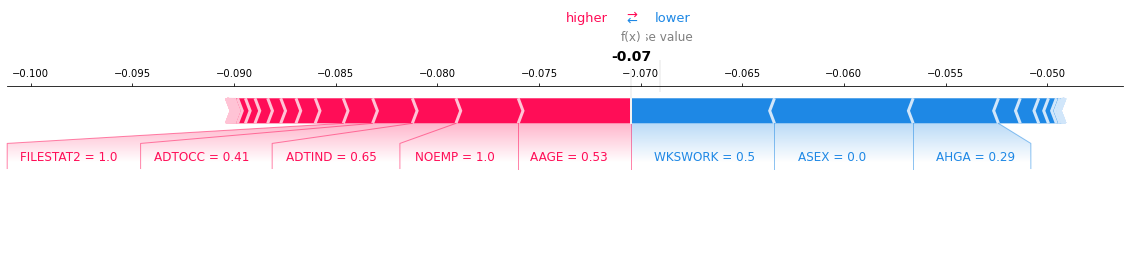

In [62]:
explainer = shap.TreeExplainer(catboost)
shap_values = explainer.shap_values(X_test)
shap.force_plot(base_value=explainer.expected_value, shap_values=shap_values[-1, :],
               features=X_test.iloc[-1, :], matplotlib=True)

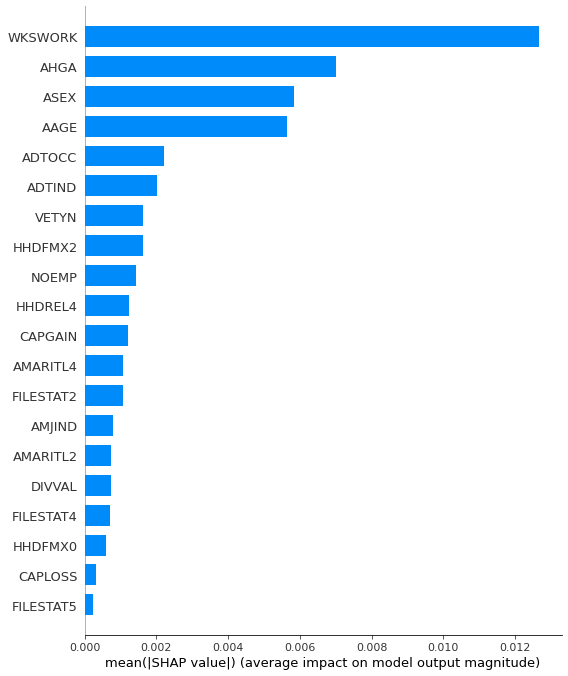

In [63]:
shap.summary_plot(shap_values, features=X_test, plot_type='bar')